# Object Detection

Once we have a segmented image, the last step is to interpret the different regions and extract the measurements or labels that we want. Exactly how this is done will vary wildly depending on what measurements we are looking for and what kind of objects we are targeting.

In this notebook, we will look at a basic case study of tracking a reflective target. In particular, we will be looking at the loading bay from the 2020 FRC game, Infinite Recharge. In the middle of the loading bay we have a rectangle of reflective tape. 

Let's say we wish to implement an automated loading routine, so that the robot can automatically line up and drive to the loading bay. Let's break down what this requires from our CV pipeline.
1. Input: We expect the loading bay vision target to be reflecting the green vision light from our robot.
2. Segmentation: We need to extract the green regions matching the vision target
3. Object detection: We need to find the position of the target in the image.
4. Outputs: We need to provide the distance from the camera/robot to the target.


But first, let's make sure we have the packages and data we need imported.


In [ ]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9)

print("Import done!")

! git clone https://github.com/Tino-FRC-2473/CVTraining repo_files

## Input data

In the data directory for this notebook is a set of simulated field images at various distances from the target (2, 5, 10 meters). In addition, both an idealized and realistic chroma keyed segmentation mask are provided.

In [ ]:
rgb_image = cv2.cvtColor(cv2.imread('repo_files/data/2020Field/image_2m.png'), cv2.COLOR_BGR2RGB)
mask = cv2.threshold(cv2.imread('repo_files/data/2020Field/targetonly_2m.png', cv2.IMREAD_GRAYSCALE), 128, 255, cv2.THRESH_BINARY)[1]

In [ ]:
plt.figure()
plt.title("Input image")
plt.imshow(rgb_image)
plt.figure()
plt.title("Target mask")
plt.imshow(mask, cmap='gray')

## Object detection strategy

So how exactly are we going to go from this mask to the distance to the robot? At a high level, there are two major ideas we are going to use. First, we are going to use _image contours_ to find the outline of the vision target and measure its size. Then we are going to use the _pinhole camera model_ to figure out how far we are from the target based on how big it appears in the image.

## Image Contours

The OpenCV method [`cv2.findContours()`](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a) traces out areas of a mask and returns a series of points making up a contour around each area it finds. You can think of a contour as an "outline" separating True and False regions of the image. As you might imagine, this is a very powerful function!

This function take three arguments.
* The first is the mask image to be processed.
* The second is a mode of operation. The full list of operations can be found under [RetrievalModes](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga819779b9857cc2f8601e6526a3a5bc71). This basically controls how findContours handles holes. In this case we will use `cv2.RETR_EXTERNAL`, which tells findContours to ignore holes and only give us the outermost outline of the target. If we cared about both the inside and outside, we could choose one of the other modes.
* The third argument selects which algorithm to use for tracing the contour. The full list of algorithms is under [ContourApproximationModes](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga4303f45752694956374734a03c54d5ff). For the purposes of this exercise, we will use `cv2.CHAIN_APPROX_SIMPLE`. However in a real pipeline, it's worth exploring all the different options. Each algorithm has its own tradeoffs and advantages/disadvantages.


In [ ]:
contours, hiearchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

The function outputs a tuple of two arrays. The first is a list of the contours found. Each contour is a list of row column coordinates of each vertex of the contour. The second array is a hiearchical index. This is useful if you are using the other modes of operations to figure out which contours are inside other contours. For our case, since we've specified `cv2.RETR_EXTERNAL` we can ignore this for now.

Let's use the drawContours function to draw the contour in magenta on the original image. Note you have to make a copy of the input image, otherwise drawContours will overwrite the original image!

In [ ]:
plt.imshow(cv2.drawContours(rgb_image.copy(), contours, -1, (255,0,255), 3))

## Noise Reduction

Of course, a real segmentation mask won't just have a perfectly isolated target. In reality, the camera will also pick up reflections and other noise. The `chromakey_#m.png` images are more realistic masks produced using a basic color segmentation scheme as discussed in the previous notebook. Let's take a look:

In [ ]:
realistic_mask = cv2.threshold(cv2.imread('repo_files/data/2020Field/chromakey_2m.png', cv2.IMREAD_GRAYSCALE), 128, 255, cv2.THRESH_BINARY)[1]
plt.figure()
plt.title("Perfect mask")
plt.imshow(mask, cmap='gray')
plt.figure()
plt.title("Realistic mask")
plt.imshow(realistic_mask, cmap='gray')

Notice how the reflections of the CV light off the field edges are creating some speckles of noise, even after the segmentation. If we just run the contour finding directly, OpenCV will be able to find the correct contour but will also find a bunch of unrelated contours as it tries to trace every little speck of noise in the image.

In [ ]:
noisy_contours,h = cv2.findContours(realistic_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(cv2.drawContours(rgb_image.copy(), noisy_contours, -1, (255,0,255), 3))

Let's look at some techniques for getting rid of the noise.

### Filtering

If you look closely at the mask image, a lot of the noise consists of small specks only a couple pixels large dotted across the image. This is often called "shot noise." One easy way to get rid of small specks is to use a median filter. What this filter does is simply set each pixel to be the median of the pixels around it. If there's only one speck of noise in the middle of an otherwise dark area, the median will still be dark. However, if we're looking at an actual target, we expect most of the pixels to be light so the median will also be light. As a result, the median filter can help to remove shot noise and fill in small holes in otherwise filled regions.

[cv2.medianBlur](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9) takes two parameters. The first is the image to be filtered. The second is the window size around each pixel to calculate the median of. For instance, for a window size of 5, it will use the median of a 5x5 pixel region centered on each pixel. Note that size must be an odd number, otherwise there's no way to center it on a single pixel.

In [ ]:
filtered_mask = cv2.medianBlur(realistic_mask, 5)

plt.figure()
plt.title("Unfiltered mask")
plt.imshow(realistic_mask, cmap='gray')
plt.figure()
plt.title("Filtered mask")
plt.imshow(filtered_mask, cmap='gray')

plt.figure()
filtered_contours,h = cv2.findContours(filtered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(cv2.drawContours(rgb_image.copy(), filtered_contours, -1, (255,0,255), 3))

You can see all the noise under the target and much of the reflection to the right has been removed. However, also take a look at the corners of the target. What happens as you increase the window size of the median filter?

_Write your response here_

## Contour Properties

Even after filtering, there are often still some large blobs of noise or reflections that are hard to get rid of. In addition, there are often multiple vision targets on the field with different shapes. How do we select only the target we want? We can look at the properties of the contours themselves to isolate the targets we want to focus on.

### Contour Area
First off, we can look at the area of the contour. Generally the vision target is going to be the biggest contour in the mask. So let's go through the list of contours and pick out the one with the biggest area. OpenCV helpfully provides the [contourArea()](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga2c759ed9f497d4a618048a2f56dc97f1) function to calculate the area of a single contour.

In [ ]:
# Return the largest contour from the provided list of contours
def find_largest_contour(contours):
  # WRITE CODE HERE
  return largest

largest_contour = find_largest_contour(filtered_contours)
print("The larget contour's area is:", cv2.contourArea(largest_contour))
plt.imshow(cv2.drawContours(rgb_image.copy(), [largest_contour], -1, (255,0,255), 3))

### Bounding Rectangle

Finally, let's find the width and height of the contour in pixels. [boundingRect()](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga103fcbda2f540f3ef1c042d6a9b35ac7) takes in a contour and draws a rectangle that perfectly contains the contour. It returns the x,y coordinates of the top left corner plus the width and height of the bounding rectangle in pixels. These pixel values will be the key for finding the distance to the target.

In [ ]:
x,y,width,height = cv2.boundingRect(largest_contour)
print("Width:", width)
print("Height:", height)

### Contour Aspect Ratio

But what if there are multiple vision targets in the image? For instance, let's look at the image taken farther away from the loading station. We can still see the loading station's vision target, but in the top right corner we are also starting to see the vision target on the shooting goal. Let's go over some options for telling these apart.

First let's take a look at the image and its contours

In [ ]:
rgb_image_10m = cv2.cvtColor(cv2.imread('repo_files/data/2020Field/image_10m.png'), cv2.COLOR_BGR2RGB)
mask_10m = cv2.threshold(cv2.imread('repo_files/data/2020Field/chromakey_10m.png', cv2.IMREAD_GRAYSCALE), 128, 255, cv2.THRESH_BINARY)[1]

plt.figure()
plt.title("Input image")
plt.imshow(rgb_image_10m)
plt.figure()
plt.title("Target mask")
plt.imshow(mask_10m, cmap='gray')

plt.figure()
plt.title("Contours")
contours_10m,h = cv2.findContours(cv2.medianBlur(mask_10m, 7), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(cv2.drawContours(rgb_image_10m.copy(), contours_10m, -1, (255,0,255), 3))


The aspect ratio of a contour is the ratio of the width to the height of the contour. $$Aspect Ratio = \frac{width}{height}$$
A contour that is wider than it is tall with have a large aspect ratio. A skinny, tall contour will have a small aspect ratio. A square or circle will have an aspect ratio of 1.

Note that the aspect ratio is preserved regardless of distance. This means that we can use it as a basic test to rule out certain contours. For instance, in this case we know that the loading bay's vision target is taller than it is wide, so its aspect ratio must be less than 1. Meanwhile, the shooting goal's vision target is much wider than it is tall, so it has an aspect ratio larger than 1.

Let's write a new version of the filtering function that finds the largest contour that is taller than it is wide. Recall that you can use `cv2.boundingRect` to find the width and height of a contour.

In [ ]:
# Return the largest contour from the provided list of contours that is taller than it is wide
def find_largest_tall_contour(contours):
  # WRITE CODE HERE
  return largest

loading_port_contour = find_largest_tall_contour(contours_10m)
print("The loading port contour's area is:", cv2.contourArea(loading_port_contour))
x,y,width,height = cv2.boundingRect(loading_port_contour)
print("The loading port contour's aspect ratio is:", float(width) / height)
plt.imshow(cv2.drawContours(rgb_image_10m.copy(), [loading_port_contour], -1, (255,0,255), 3))

### Bounding Box Fill Ratio

One last metric we'll look at is the bounding box fill ratio. This basically takes the bounding box of the contour, and looks at what ratio of pixels within the box are actually marked as true in the mask. The more "filled in" the bounding box, the closer to 100% the fill ratio will be.

$$\text{Fill ratio} = \frac{\text{Number of filled pixels}}{\text{Bounding box width} \times \text{Bounding box height}}$$

Where this comes in handy is you have a target with a hole in it or a U shape. Most random blobs of noise will be generally convex, filling most of their bounding box. It is very unusual to have a doughnut shaped or U shaped blob of noise. Thus, if we calculate the fill ratio we expect from our target, this can be a very good way to find the target we are looking for. Even better, the fill ratio is highly dependent on the shape of the target, so it can be used to identify different or oddly shaped targets.



Let's first calculate by hand what we expect the fill ratio to be. Here's the drawing of the loading port vision target from the 2020 game manual. **The reflective tape is 2" wide**

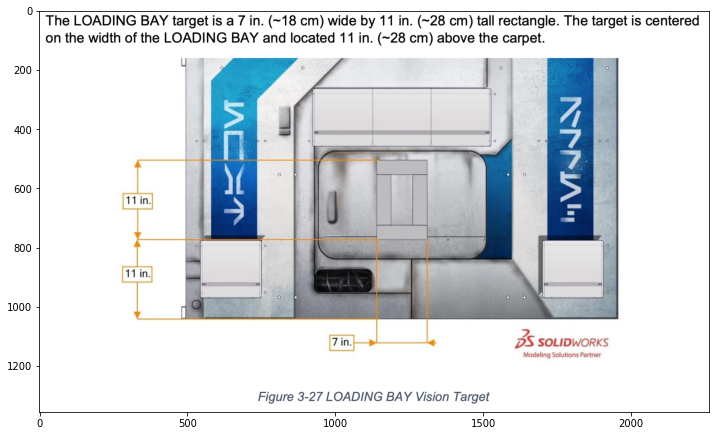

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread('repo_files/data/LoadingBayDiagram.png'), cv2.COLOR_BGR2RGB))

Let's save the fill ratio as a constant:

In [ ]:
LOADING_BAY_FILL_RATIO = 0.0 # REPLACE WITH YOUR VALUE

To implement the fill ratio calculation, first let's slice out the pixels that are in the bounding box and run a count of how many of them are filled in. Then divide by the area of the bounding box.

Here's an example of how to use Numpy slicing to select the pixels inside a contour's bounding box:

In [ ]:
# Example of Numpy slicing a bounding box
plt.figure()
plt.title("Slice of shooting target's bounding box")
shooting_target_contour = find_largest_contour(contours_10m)
# Find the contour bounding box
x,y,width,height = cv2.boundingRect(shooting_target_contour)
# Numpy slice out these pixels from the mask
plt.imshow(mask_10m[y:y+height, x:x+width], cmap="gray")

Now write a function to calculate the numerator of the fill ratio, how many pixels are filled within the bounding box of the contour.

In [ ]:
# Return the fill ratio of the provided contour's bounding box, taking pixels from the provided mask.
def bbox_fill_ratio(contour, mask):
  # WRITE CODE HERE
  return np.count_nonzero(bounding_box) / float(width * height)

print("Shooting target fill ratio (Should be about 0.18):", bbox_fill_ratio(shooting_target_contour, mask_10m))

Finally, let's write a function to go through all the contours returned from findContours and pick out the one with the fill ratio closest to our target value.

In [ ]:
# Find the contour from the list of contours that has a fill ratio closest to the provided target fill ratio
def find_closest_fill_ratio_contour(contours, mask, target_fill_ratio):
  # WRITE CODE HERE
  return best_contour

loading_port_contour = find_closest_fill_ratio_contour(contours_10m, mask_10m, LOADING_BAY_FILL_RATIO)
print("The loading port fill ratio is:", bbox_fill_ratio(loading_port_contour, mask_10m))
plt.imshow(cv2.drawContours(rgb_image_10m.copy(), [loading_port_contour], -1, (255,0,255), 3))

## Final summary

In this lesson we've gone over how to use image contours to clean up and identify specific targets in a segmented image mask. Let's finish up by putting everything together into one function that returns the contour of the loading bay target given the mask image. You'll need to clean up the mask image, find the contours, then use any of the strategies from above to pick out the loading bay vision target.

In [ ]:
# Given the segmented image mask, return the (x,y) pixel coordinates of the center of the loading bay vision target as a tuple.
def find_loading_port(mask):
  # WRITE CODE HERE
  return target_contour

rgb_image_5m = cv2.cvtColor(cv2.imread('repo_files/data/2020Field/image_5m.png'), cv2.COLOR_BGR2RGB)
mask_5m = cv2.threshold(cv2.imread('repo_files/data/2020Field/chromakey_5m.png', cv2.IMREAD_GRAYSCALE), 128, 255, cv2.THRESH_BINARY)[1]
target_contour = find_loading_port(mask_5m)

# Draw the contour in pink
plt.imshow(cv2.drawContours(rgb_image_5m.copy(), [target_contour], -1, (255,0,255), 3))